# Practical Worksheet

In this worksheet, we will be working with a small dataset of hyponym-hypernym pairs. Hyponymy is the `is-a` relation. So we will have pairs like `(cat, mammal)` meaning 'A cat is a mammal'. The hyponym is the more specific term (e.g., cat) and the hypernym is the more general term (e.g., mammal). In this notebook you will:

1. (3 pts) Use Logical Neural Networks with a very small hyponym dataset to infer a set of facts. You will discuss the kinds of facts that you can infer and the limitations of the model as it is implemented
2. (5 pts) Set up a Logic Tensor Network to learn word embeddings and predicates that can model a larger hyponymy dataset.
3. (5 pts) Evaluate the effect of different axioms in the LTN system.
4. (2 pts) Query your model.


## Part 0. Setup
Create an environment and install python 3.12, numpy, pandas, and scikit-learn.

Install LNNs using `pip install git+https://github.com/IBM/LNN`

Install LTNs using `pip install LTNtorch`

Import packages as below.

In [64]:
import pandas as pd
import numpy as np
import torch
!pip install ltntorch
import ltn

## Part 1. Inferring facts using Logical Neural Networks

In this first part, we will manually specify a very small dictionary of hyponym facts. We have three hyponyms and three non-hyponyms. The hyponymy relation is transitive, meaning that if $x$ is a hyponym of $y$ and $y$ is a hyponym of $z$, then $x$ should be a hyponym of $z$.

You will:

a. (1.5 pt) Set up a LNN model with suitable variables, a transitivity axiom, and hyponymy data.

b. (0.5 pt) Run inference over the model.

c. (1 pt) Inspect the output of the model and discuss whether the output is as expected.

In [65]:
# We first set up a small dictionary of hyponyms
!pip install git+https://github.com/IBM/LNN
from lnn import Fact

hyp_dict = {('cat', 'mammal'):Fact.TRUE,
            ('dog', 'mammal'):Fact.TRUE,
            ('mammal', 'animal'):Fact.TRUE,
            ('cat', 'dog'):Fact.FALSE,
            ('animal', 'mammal'):Fact.FALSE,
            ('mammal', 'dog'):Fact.FALSE,}

  Cloning https://github.com/IBM/LNN to /private/var/folders/s4/s2jtgdvn5kzc_h3h64ntjkgm0000gn/T/pip-req-build-iov151ez
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/LNN /private/var/folders/s4/s2jtgdvn5kzc_h3h64ntjkgm0000gn/T/pip-req-build-iov151ez
  Resolved https://github.com/IBM/LNN to commit 18ea03a52a79e6bbe8dada76e1ad9b320cd894d4
  Preparing metadata (setup.py) ... done


### Part 1a) (1.5 pts) Setting up the model.
Set up a LNN model with suitable predicates and variables, a transitivity axiom, and hyponymy data.

In [66]:
# Initialize an empty model
from lnn import Model
model = Model()
from lnn import Propositions, And, Implies, Iff, Fact, Model, Or
A, B, C, D, E = Propositions("A", "B", "C", "D", "E")
IMPLIES=Implies(A, B)
AND=And(C, D)
IFF=Iff(AND, E)
SENTENCE =And(IMPLIES, IFF)



In [67]:
# Create a predicate of arity 2 called Hyps and three variables x, y, z
## YOUR CODE HERE ##
from lnn import Predicate, Variable
Hyps = Predicate('Hyps', arity=2)
x = Variable('x')
y = Variable('y')
z = Variable('z')

In [68]:
# Create a logical rule that encodes the fact that the hyponymy relation is transitive
## YOUR CODE HERE ##
transitivity_rule = Implies(And(Hyps(x, y), Hyps(y, z)), Hyps(x, z))

In [69]:
# Add the knowledge and the data (the hyponymy dict) to the model and print.
## YOUR CODE HERE ##
model.add_knowledge(transitivity_rule)
model.add_data({Hyps: {
    ('cat', 'mammal'): Fact.TRUE,
    ('dog', 'mammal'): Fact.TRUE,
    ('mammal', 'animal'): Fact.TRUE,
    ('cat', 'dog'): Fact.FALSE,
    ('animal', 'mammal'): Fact.FALSE,
    ('mammal', 'dog'): Fact.FALSE,
}})
print(model)


Model()


### Part 1b) (0.5 pts) Inferring facts
Run inference over the model and print the output.

In [70]:
# Part 1b (0.5 pts) Run inference over the model and print the output 
## YOUR CODE HERE ##
model.infer()
model.print()   



***************************************************************************
                                LNN Model

OPEN Implies: ((Hyps(0, 1) ∧ Hyps(1, 2)) → Hyps(0, 2)) 
('dog', 'mammal', 'cat')                                 UNKNOWN (0.0, 1.0)
('animal', 'dog', 'mammal')                              UNKNOWN (0.0, 1.0)
('animal', 'mammal', 'animal')                              TRUE (1.0, 1.0)
('animal', 'cat', 'dog')                                    TRUE (1.0, 1.0)
('dog', 'cat', 'cat')                                    UNKNOWN (0.0, 1.0)
('cat', 'mammal', 'cat')                                 UNKNOWN (0.0, 1.0)
('animal', 'dog', 'animal')                              UNKNOWN (0.0, 1.0)
('animal', 'animal', 'animal')                           UNKNOWN (0.0, 1.0)
('cat', 'animal', 'cat')                                 UNKNOWN (0.0, 1.0)
('cat', 'dog', 'cat')                                       TRUE (1.0, 1.0)
('mammal', 'animal', 'mammal')                              TRUE

### Part 1c) (1 pt) Inspecting the output.

You should see that there are various facts whose truth value is unknown. 


Q1: Why can we not infer the truth value of all facts with the given database and axioms?




Q2: Suggest a suitable axiom to add to this system that would help to infer more facts. You do not need to implement the axiom.





Q1: Sometimes we do not knwo anything about all facts involved such as (mammel, mammel) and (mammel, cat) then we can not know (mammel, cat) since we have none of the fax and these are never mentioned so we cannot learn them either


Q2: Implies(Hyps(x,y), not(Hyps(y,x))) if one is in one group sach cat in mammel then mammel not in cat. This should help create more false examples. 

## Part 2 (5 pts) Building Embeddings with Logic Tensor Networks.
In this part, we will build a Logic Tensor Network to learn embeddings for the hyponyms. You will:

a. (1 pt) Describe why learning embeddings for the hyponyms is a suitable approach.

b. (1 pt) Set up a predicate for the hyponymy relation.

c. (1 pt) Train a simple network on the hyponymy task.

d. (2 pts) Assess satisfaction on the test set  and negative sample set


### Importing the data

Below, we import the data into pandas dataframes. Take a look at the data to familiarise yourself with the format. In each .csv file we have a list of word pairs. 
- In train_hypernyms we have the set of hypernym pairs we will train on. 
- In test_hypernyms we have the set of pairs we will test on. 
- In non_hypernyms we have a set of word pairs that are not hypernym pairs.

In [71]:
import pandas as pd

train_df = pd.read_csv('../data/train_hypernyms.csv')
test_df = pd.read_csv('../data/test_hypernyms.csv')
neg_df = pd.read_csv('../data/non_hypernyms.csv')


train_pairs = train_df.values
test_pairs = test_df.values
neg_pairs = neg_df.values

print("Training pairs:")
print(train_pairs[:5])

print("Testing pairs:")
print(test_pairs[:5])

print("Negative pairs:")
print(neg_pairs[:5])


Training pairs:
[['supermarket' 'commercial building']
 ['hand tool' 'tool']
 ['peach' 'fruit']
 ['pike' 'fish']
 ['nail gun' 'power tool']]
Testing pairs:
[['workshop' 'building']
 ['train' 'vehicle']
 ['pine' 'physical object']
 ['snare drum' 'physical object']
 ['grape' 'physical object']]
Negative pairs:
[['jigsaw' 'nail gun']
 ['temple' 'synagogue']
 ['double bass' 'banjo']
 ['turkey' 'turkey']
 ['crocodile' 'snake']]


### Part 2a. (1 pt) Learning Embeddings

When we use a logic tensor network, we can choose to use data from outside sources or to train embeddings within the network. We will be training embeddings. Do you think this is a suitable approach for this dataset? Why or why not?

YOUR ANSWER HERE
This is a suitable aproach for the data set since we do have embeddings in the data so we should either train or get an universal embedder but those already contain relation information. Giving a lot of unwanted information to the model.

Below, we will set up the vocabulary and the initial random word embeddings to be trained.

In [72]:
# Build a set of vocab by taking the union of the hyponyms and hypernyms
vocab = set(train_df.hyper.unique()).union(train_df.hypo.unique())

# Set the dimension of the vocab to 10
vocab_dim = 10

# Build a dictionary of word embeddings initialised randomly and set to be trainable.
word_embeddings = {word: ltn.Constant(torch.rand((vocab_dim,)), trainable=True) \
                   for word in vocab}



### Part 2b. (1 pt) Defining a predicate.
Define a predicate as a feed-forward NN with ELU and sigmoid activation functions and one hidden layer of size 16

In [73]:
# Define a feed-forward NN  with ELU and sigmoid activation functions and one hidden layer of size 16.
class ModelHyp(torch.nn.Module):
    def __init__(self):
        ## YOUR CODE HERE ##    
        super(ModelHyp, self).__init__()
        self.elu = torch.nn.ELU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.fc1 = torch.nn.Linear(2 * vocab_dim, 16)
        self.fc2 = torch.nn.Linear(16, 1)
        self.sigmoid = torch.nn.Sigmoid()



    def forward(self, *x):
        # Specify the forward pass with ELU on the hidden layers and sigmoid on the output
        x = list(x)
        x = torch.cat(x, dim=1)
        ## YOUR CODE HERE ##
        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
# Wrap the feed-forward NN to make it an LTN predicate called Hyp
Hyp = ltn.Predicate(ModelHyp())
x = ltn.Variable('x', torch.stack([word_embeddings[word].value for word in vocab]))
y = ltn.Variable('y', torch.stack([word_embeddings[word].value for word in vocab]))

# Define connectives, quantifiers, and SatAgg
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

### Part 2c. (1 pt) Training the network

We set up a simple network in which we view our knowledge base as consisting just of those pairs in the training set. So our knowledge base states that for each word pair in the training set, this is a hyponym pair. We want to maximise the satisfaction over this knowledge base. To do this, we write a suitable axiom to aggregate the satisfaction of the hyponymy predicate over these pairs, and train the parameters of the network.

In [74]:
# We have to optimize the parameters of the predicate and also of the embeddings
params = list(Hyp.parameters()) +[i.value for i in word_embeddings.values()]
optimizer = torch.optim.Adam(params, lr=0.001)

# Set up a training loop for 300 epochs
for epoch in range(300):    
    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    sat_agg = SatAgg(
# Implement one axiom which aggregates the satisfaction across the (x, y) in train_pairs
        ## YOUR CODE HERE ##
        *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs]
        ,
        

        # Our list of hyponym pairs is in train_pairs.
        # We want to maximise the satisfaction gained by inputting the embeddings of those words into
        # our hyponymy predicate
        
        

    )
    
    loss = 1. - sat_agg
    loss.backward()
    optimizer.step()

    # Print metrics every 20 epochs of training
    if epoch % 20 == 0:
        print(f" epoch {epoch} | loss {loss} | Train Sat {sat_agg}")

 epoch 0 | loss 0.5354474782943726 | Train Sat 0.46455252170562744
 epoch 20 | loss 0.41495490074157715 | Train Sat 0.5850450992584229
 epoch 40 | loss 0.27735888957977295 | Train Sat 0.722641110420227
 epoch 60 | loss 0.143571674823761 | Train Sat 0.856428325176239
 epoch 80 | loss 0.05447441339492798 | Train Sat 0.945525586605072
 epoch 100 | loss 0.01591414213180542 | Train Sat 0.9840858578681946
 epoch 120 | loss 0.003917038440704346 | Train Sat 0.9960829615592957
 epoch 140 | loss 0.0008976459503173828 | Train Sat 0.9991023540496826
 epoch 160 | loss 0.0002428293228149414 | Train Sat 0.9997571706771851
 epoch 180 | loss 0.00012165307998657227 | Train Sat 0.9998783469200134
 epoch 200 | loss 0.00010293722152709961 | Train Sat 0.9998970627784729
 epoch 220 | loss 0.00010037422180175781 | Train Sat 0.9998996257781982
 epoch 240 | loss 0.00010001659393310547 | Train Sat 0.9998999834060669
 epoch 260 | loss 0.00010001659393310547 | Train Sat 0.9998999834060669
 epoch 280 | loss 0.00010

### Part 2d (2 pts) Assessing the satisfaction on the test set

Calculate the satisfaction over the test set using SatAgg. Do you think the model is generalising well? Now calculate the satisfaction over the negative samples dataset. Is this a suitable satisfaction level? Why or why not?

YOUR ANSWER HERE

The model performs well on the test set, having a satisfaction of 0.99 which means that it has an almost perfect generelisability to the test set. This is the same for the negative emmbeddings as those also have a high score of 0.99

In [75]:
test_vocab = set(test_df.hyper.unique()).union(test_df.hypo.unique())
test_x = ltn.Variable('x', torch.stack([word_embeddings[word].value for word in test_vocab]))
test_y = ltn.Variable('y', torch.stack([word_embeddings[word].value for word in test_vocab]))
neg_vocab = set(neg_df.hyper.unique()).union(neg_df.hypo.unique())
neg_x = ltn.Variable('x', torch.stack([word_embeddings[word].value for word in neg_vocab]))
neg_y = ltn.Variable('y', torch.stack([word_embeddings[word].value for word in neg_vocab]))

In [76]:
satisfaction_test = SatAgg(*[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in test_pairs],)
satisfaction_neg = SatAgg(*[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in neg_pairs],)
print(f"the satisfaction of the test dataset is: {satisfaction_test}")

print(f"the satisfaction of the negative dataset is: {satisfaction_neg}")

the satisfaction of the test dataset is: 0.9998999834060669
the satisfaction of the negative dataset is: 0.9998999834060669


## Part 3. (5 pts) Evaluate the effect of different axioms in the LTN system

In this part you will:

a. (2 pts) Retrain the model and evaluate the performance with negation included

b. (2 pts) Retrain the model and evaluate performance with transitivity included

c. (1 pt) Discuss the effect of the different axioms introduced.

### Part 3a. (2pts)  Retraining the model with negation
Reinitialise the model and retrain, including information from the `neg_pairs` dataset.

In [77]:
# Reinitialise the model
Hyp = ltn.Predicate(ModelHyp())

In [78]:
# Set up the parameters and optimizer
## YOUR CODE HERE ##
params = list(Hyp.parameters()) +[i.value for i in word_embeddings.values()]
optimizer = torch.optim.Adam(params, lr=0.001)


# Set up a training loop for 300 epochs
    ## YOUR CODE HERE ##

for epoch in range(300):
    
    
    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
        ## YOUR CODE HERE ##
        sat_agg = SatAgg(
        # Implement one axiom which aggregates the satisfaction across the (x, y) in train_pairs
        ## YOUR CODE HERE ##
        *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],
        

        # Implement one axiom which aggregates the satisfaction across the (x, y) in neg_pairs
        # Note that this statement should involve a negation.
        ## YOUR CODE HERE ##
        *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in neg_pairs],)

    # Calculate the loss and propagate backwards
    ## YOUR CODE HERE ##
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()

    # Print metrics every 20 epochs of training
    ## YOUR CODE HERE ##
        if epoch % 20 == 0:
            print(f" epoch {epoch} | loss {loss} | Train Sat {sat_agg}")

 epoch 0 | loss 0.4354308843612671 | Train Sat 0.5645691156387329
 epoch 20 | loss 0.2482622265815735 | Train Sat 0.7517377734184265
 epoch 40 | loss 0.10261768102645874 | Train Sat 0.8973823189735413
 epoch 60 | loss 0.03187155723571777 | Train Sat 0.9681284427642822
 epoch 80 | loss 0.008226394653320312 | Train Sat 0.9917736053466797
 epoch 100 | loss 0.0019223690032958984 | Train Sat 0.9980776309967041
 epoch 120 | loss 0.0004655122756958008 | Train Sat 0.9995344877243042
 epoch 140 | loss 0.00016433000564575195 | Train Sat 0.9998356699943542
 epoch 160 | loss 0.0001100301742553711 | Train Sat 0.9998899698257446
 epoch 180 | loss 0.00010144710540771484 | Train Sat 0.9998985528945923
 epoch 200 | loss 0.00010019540786743164 | Train Sat 0.9998998045921326
 epoch 220 | loss 0.00010001659393310547 | Train Sat 0.9998999834060669
 epoch 240 | loss 0.00010001659393310547 | Train Sat 0.9998999834060669
 epoch 260 | loss 0.00010001659393310547 | Train Sat 0.9998999834060669
 epoch 280 | loss

In [79]:
# Calculate the satisfaction across the test dataset and the negated dataset
satisfaction_test = SatAgg(*[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in test_pairs])
satisfaction_neg = SatAgg(*[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in neg_pairs])
print(f"the satisfaction of the test dataset is: {satisfaction_test.item()}")

print(f"the satisfaction of the negative dataset is: {satisfaction_neg.item()}")

the satisfaction of the test dataset is: 0.9998999834060669
the satisfaction of the negative dataset is: 0.9998999834060669


### Part 3b. (2 pts) Retraining the model with transitivity

As we discussed in Part 1, the hyponymy relation is transitive. This should be reflected in the axioms. Reinitialise the model and add an axiom expressing the rule:

$\forall x, y, z Hyp(x, y) \land Hyp(y, z) \implies Hyp(x, z)$

Retrain the model and evaluate on the test and negated datasets.

In [80]:
# Reinitialise the model
## YOUR CODE HERE ##
Hyp = ltn.Predicate(ModelHyp())

In [81]:
# Set up the parameters and optimizer
## YOUR CODE HERE ##
params = list(Hyp.parameters()) +[i.value for i in word_embeddings.values()]
optimizer = torch.optim.Adam(params, lr=0.001)


# Set up a training loop for 300 epochs
## YOUR CODE HERE ##
for epoch in range(300):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##
    x_ = ltn.Variable('x_', torch.stack([word_embeddings[word].value for word in vocab]))
    y_ = ltn.Variable('y_', torch.stack([word_embeddings[word].value for word in vocab]))
    z_ = ltn.Variable('z_', torch.stack([word_embeddings[word].value for word in vocab]))

    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
    sat_agg = SatAgg(
        
        #Positive instances of hyponymy
        ## YOUR CODE HERE ##
        *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],

        #Negative instances of hyponymy
        ## YOUR CODE HERE ##
        *[Not(Hyp(word_embeddings[x], word_embeddings[y])) for x, y in neg_pairs],
        
        # Transitivity axiom
        ## YOUR CODE HERE ##
        Forall([x_, y_, z_],
                Implies(And(Hyp(x_, y_), Hyp(y_, z_)), Hyp(x_, z_))

    ))
    # Calculate the loss and propagate backwards
    ## YOUR CODE HERE ##
    loss = 1. - sat_agg
    loss.backward()
    optimizer.step()

    # Print metrics every 20 epochs of training
    ## YOUR CODE HERE ##
    if epoch % 20 == 0:
        print(f" epoch {epoch} | loss {loss} | Train Sat {sat_agg}")

 epoch 0 | loss 0.493239164352417 | Train Sat 0.506760835647583
 epoch 20 | loss 0.4714892506599426 | Train Sat 0.5285107493400574
 epoch 40 | loss 0.4414280652999878 | Train Sat 0.5585719347000122
 epoch 60 | loss 0.445223331451416 | Train Sat 0.554776668548584
 epoch 80 | loss 0.36393749713897705 | Train Sat 0.636062502861023
 epoch 100 | loss 0.42139971256256104 | Train Sat 0.578600287437439
 epoch 120 | loss 0.37711620330810547 | Train Sat 0.6228837966918945
 epoch 140 | loss 0.24278724193572998 | Train Sat 0.75721275806427
 epoch 160 | loss 0.4706493616104126 | Train Sat 0.5293506383895874
 epoch 180 | loss 0.24879395961761475 | Train Sat 0.7512060403823853
 epoch 200 | loss 0.15658706426620483 | Train Sat 0.8434129357337952
 epoch 220 | loss 0.36154860258102417 | Train Sat 0.6384513974189758
 epoch 240 | loss 0.41336846351623535 | Train Sat 0.5866315364837646
 epoch 260 | loss 0.2295083999633789 | Train Sat 0.7704916000366211
 epoch 280 | loss 0.12436914443969727 | Train Sat 0.87

In [82]:
# Calculate the satisfaction across the test dataset and the negated dataset
satisfaction_test = SatAgg(*[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in test_pairs])
satisfaction_neg = SatAgg(*[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in neg_pairs])
print(f"the satisfaction of the test dataset is: {satisfaction_test.item()}")

print(f"the satisfaction of the negative dataset is: {satisfaction_neg.item()}")

the satisfaction of the test dataset is: 0.992763102054596
the satisfaction of the negative dataset is: 0.022181451320648193


### Part 3c. (1 pt)  Evaluating the model
How has the satisfaction changed across the test set and the set of negative examples as you include different axioms? Why has this happened? Write a couple of sentences with your conclusions about the datasets and the model you have built. 

YOUR ANSWER HERE
The satisfaction is great on the test set meaning the model does understand transitivity over new data, however the model struggles with the negative examples on the transitivity data set, this migth happen since we do not have a lot of pure non transitive examples. meaning that the model does not see wrong examples often enough

## Part 4 (2 pts) Querying the model

One of the strengths of Logic Tensor Networks is that you are able to query the models you have built. In this part you will:

a. (0.5 pts) Define a logical statement that you expect to hold in your model.

b. (1 pt) Query the model.

c. (0.5 pts) Discuss your result.

### Part 4a. (0.5 pts) Defining a query

Thinking about the properties of hyponymy, give a logical statement that you would expect to hold in your model. The statement can be quite simple.

YOUR ANSWER HERE

Since no word is a hyponym of themselfs we can say that Hyp(x,y) -> Not(Hyp(y,x))

### Part 4b. (1 pt) Querying the model

Write a function that returns the satisfaction level of your logical statement and determine the satisfaction level.

In [83]:
# this function returns the satisfaction level of your logical formula
def phi():
    # Create variables p, q, and r and initialize with the values from 'word_embeddings'
    ## YOUR CODE HERE ##
    p = ltn.Variable('p', torch.stack([word_embeddings[word].value for word in vocab]))
    q = ltn.Variable('q', torch.stack([word_embeddings[word].value for word in vocab]))
    # Return the truth value of phi
    ## YOUR CODE HERE ##
    return Forall([p, q], 
                  Implies(Hyp(p, q), Not(Hyp(q, p))))
                  

In [84]:
# Evaluate phi

## YOUR CODE HERE ##
Phi = phi()
print(f"The evaluation of phi is: {Phi.value}")

The evaluation of phi is: 0.8223963975906372


### Part 4c. (0.5 pts) Discuss the results

Was the satisfaction value what you expected to see? Why or why not?


YOUR ANSWER HERE
The satisfaction is way lower than expected, since we now that now formula is hyponym of themself, we know that the formula should hold. However in this model it seems to have a satisfaction o arounf 0.4 which suggest it does not hold. The error migth ensue because the model is still bad at handeling the negative examples 

## Wrap up

In this worksheet, we looked at the hyponymy relation that can hold between words.

1. We used Logical Neural Networks with a very small hyponym dataset to infer a set of facts, and discussed the kinds of facts that you can infer and the limitations of the model as it is implemented.
2. We set up a Logic Tensor Network to learn word embeddings and predicates that can model a larger hyponymy dataset.
3. We evaluated the effect of different axioms in the LTN system.
4. And finally, you queried your model with new logical statements.

For another 15 points, you can extend this worksheet in a number of different ways. 

### Possible extensions

1. Use a new dataset for the task of inferring relationships over data.
2. Use the same dataset with a different model that we have covered in class. You could potentially use Logical Neural Networks, although they are a little slow.
3. Extend the investigation already started in this notebook. How do you expect the hyponymy relation to behave? Can you improve performance on novel queries?
4. Extend this investigation by including semantic information into the word embeddings from external sources.
5. Other ideas? Feel free to discuss with me!



The previous part of the note book highligthed the issue that the LTN does not generelisize well to novel formula's. The next part of the notebook will extend to on this by looking if the LTN is better capable of generelising to a novel formula, if it is trained on all subparts of the formula. And to what extend training on those subparts impact the formula. To show this we will train the model to understand a version of the transitivity formula; (Hyp(x,y) & Hyp(y,z)) -> NOT(hyp(z,x))

This research is set up as follows, 4 models will be trained on different formulas, one on only the hyp(x,y) relation, one on hyp(x,y) and not(hyp(x,y)), one will also learn the transitivi (Hyp(x,y) & Hyp(y,z))-> Hyp(x,z) next to to the previuosly mentioned formulas. And the last model will just learn the (Hyp(x,y) & Hyp(y,z)) -> NOT(hyp(z,x)) relation to function as baseline. All models will be trained 5 times to account for the variance in training.  IF possible the model will be trained on 3 different amount of epochs (100, 300, 500) to account for an increase of training times with more formulas.

In [85]:
# Set up the parameters and optimizer
## YOUR CODE HERE ##
params = list(Hyp.parameters()) +[i.value for i in word_embeddings.values()]
optimizer = torch.optim.Adam(params, lr=0.001)
hyp_only = []
hyp_only_100 = []
hyp_only_500 = []
hyp_neg_only = []
hyp_neg_only_100 = []
hyp_neg_only_500 = []
hyp_neg_transitivity = []
hyp_neg_transitivity_100 = []
hyp_neg_transitivity_500 = []
baseline_psi = []
baseline_psi_100 = []
baseline_psi_500 = []

def get_val(item):
    if isinstance(item, ltn.Constant):
        return item.value.item()
    else:
        return item.value

def psi():
    # Create variables p, q, and r and initialize with the values from 'word_embeddings'
    ## YOUR CODE HERE ##
    p = ltn.Variable('p', torch.stack([word_embeddings[word].value for word in vocab]))
    q = ltn.Variable('q', torch.stack([word_embeddings[word].value for word in vocab]))
    r = ltn.Variable('r', torch.stack([word_embeddings[word].value for word in vocab]))
    # Return the truth value of psi
    ## YOUR CODE HERE ##
    return Forall([p, q, r], 
                  Implies(And(Hyp(p, q), Hyp(q, r)), Not(Hyp(r, p))))




In [86]:
Hyp = ltn.Predicate(ModelHyp())
# training with only the positive hyponymy instances
for i in range(5):
    for epoch in range(300):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##

    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            
            #Positive instances of hyponymy
            ## YOUR CODE HERE ##
            *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],

        )
        # Calculate the loss and propagate backwards
        ## YOUR CODE HERE ##
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()

        # Print metrics every 100 epochs of training
        ## YOUR CODE HERE ##
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    hyp_only.append(get_val(psi_value))

 epoch 0-0 | loss 0.3917328119277954 | Train Sat 0.6082671880722046
 epoch 0-100 | loss 0.39126354455947876 | Train Sat 0.6087364554405212
 epoch 0-200 | loss 0.38779354095458984 | Train Sat 0.6122064590454102
 epoch 1-0 | loss 0.38155853748321533 | Train Sat 0.6184414625167847
 epoch 1-100 | loss 0.3728131055831909 | Train Sat 0.6271868944168091
 epoch 1-200 | loss 0.3621492385864258 | Train Sat 0.6378507614135742
 epoch 2-0 | loss 0.35018718242645264 | Train Sat 0.6498128175735474
 epoch 2-100 | loss 0.33748459815979004 | Train Sat 0.66251540184021
 epoch 2-200 | loss 0.32445114850997925 | Train Sat 0.6755488514900208
 epoch 3-0 | loss 0.3113445043563843 | Train Sat 0.6886554956436157
 epoch 3-100 | loss 0.29831910133361816 | Train Sat 0.7016808986663818
 epoch 3-200 | loss 0.28548431396484375 | Train Sat 0.7145156860351562
 epoch 4-0 | loss 0.2729116678237915 | Train Sat 0.7270883321762085
 epoch 4-100 | loss 0.2606469392776489 | Train Sat 0.7393530607223511
 epoch 4-200 | loss 0.24

In [87]:
Hyp = ltn.Predicate(ModelHyp())
# training with only the positive hyponymy instances
for i in range(5):
    for epoch in range(100):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##

    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            
            #Positive instances of hyponymy
            ## YOUR CODE HERE ##
            *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],

        )
        # Calculate the loss and propagate backwards
        ## YOUR CODE HERE ##
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()

        # Print metrics every 100 epochs of training
        ## YOUR CODE HERE ##
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    hyp_only_100.append(get_val(psi_value))

 epoch 0-0 | loss 0.5113574266433716 | Train Sat 0.4886425733566284
 epoch 1-0 | loss 0.5103450417518616 | Train Sat 0.4896549582481384
 epoch 2-0 | loss 0.5059924125671387 | Train Sat 0.49400758743286133
 epoch 3-0 | loss 0.4995792508125305 | Train Sat 0.5004207491874695
 epoch 4-0 | loss 0.49176084995269775 | Train Sat 0.5082391500473022


In [88]:
Hyp = ltn.Predicate(ModelHyp())
# training with only the positive hyponymy instances
for i in range(5):
    for epoch in range(500):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##

    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            
            #Positive instances of hyponymy
            ## YOUR CODE HERE ##
            *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],

        )
        # Calculate the loss and propagate backwards
        ## YOUR CODE HERE ##
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()

        # Print metrics every 100 epochs of training
        ## YOUR CODE HERE ##
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    hyp_only_500.append(get_val(psi_value))

 epoch 0-0 | loss 0.5181787014007568 | Train Sat 0.48182129859924316
 epoch 0-100 | loss 0.5214996337890625 | Train Sat 0.4785003662109375
 epoch 0-200 | loss 0.5159562826156616 | Train Sat 0.4840437173843384
 epoch 0-300 | loss 0.5031071901321411 | Train Sat 0.4968928098678589
 epoch 0-400 | loss 0.4849942922592163 | Train Sat 0.5150057077407837
 epoch 1-0 | loss 0.4632496237754822 | Train Sat 0.5367503762245178
 epoch 1-100 | loss 0.4392642378807068 | Train Sat 0.5607357621192932
 epoch 1-200 | loss 0.41425085067749023 | Train Sat 0.5857491493225098
 epoch 1-300 | loss 0.38917791843414307 | Train Sat 0.6108220815658569
 epoch 1-400 | loss 0.36472034454345703 | Train Sat 0.635279655456543
 epoch 2-0 | loss 0.3412650227546692 | Train Sat 0.6587349772453308
 epoch 2-100 | loss 0.3189953565597534 | Train Sat 0.6810046434402466
 epoch 2-200 | loss 0.29796719551086426 | Train Sat 0.7020328044891357
 epoch 2-300 | loss 0.2781428098678589 | Train Sat 0.7218571901321411
 epoch 2-400 | loss 0.

In [89]:
# reinitialise the model
Hyp = ltn.Predicate(ModelHyp())
# training with both positive and negative hyponymy instances
for i in range(5):
    for epoch in range(300):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##

    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            
            #Positive instances of hyponymy
            *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],
            #Negative instances of hyponymy
            *[Not(Hyp(word_embeddings[x], word_embeddings[y])) for x, y in neg_pairs],
        )
        # Calculate the loss and propagate backwards
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        # Print metrics every 100 epochs of training
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    hyp_neg_only.append(get_val(psi_value))

 epoch 0-0 | loss 0.6642690896987915 | Train Sat 0.3357309103012085
 epoch 0-100 | loss 0.6656230688095093 | Train Sat 0.3343769311904907
 epoch 0-200 | loss 0.6660171747207642 | Train Sat 0.33398282527923584
 epoch 1-0 | loss 0.6656084060668945 | Train Sat 0.33439159393310547
 epoch 1-100 | loss 0.6645381450653076 | Train Sat 0.3354618549346924
 epoch 1-200 | loss 0.6629172563552856 | Train Sat 0.33708274364471436
 epoch 2-0 | loss 0.6608361601829529 | Train Sat 0.3391638398170471
 epoch 2-100 | loss 0.6583698987960815 | Train Sat 0.34163010120391846
 epoch 2-200 | loss 0.6555840969085693 | Train Sat 0.34441590309143066
 epoch 3-0 | loss 0.6525359153747559 | Train Sat 0.34746408462524414
 epoch 3-100 | loss 0.6492762565612793 | Train Sat 0.3507237434387207
 epoch 3-200 | loss 0.6458511352539062 | Train Sat 0.35414886474609375
 epoch 4-0 | loss 0.6423035264015198 | Train Sat 0.3576964735984802
 epoch 4-100 | loss 0.6386736631393433 | Train Sat 0.36132633686065674
 epoch 4-200 | loss 0.

In [90]:
Hyp = ltn.Predicate(ModelHyp())
# training with both positive and negative hyponymy instances
for i in range(5):
    for epoch in range(100):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##

    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            
            #Positive instances of hyponymy
            *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],
            #Negative instances of hyponymy
            *[Not(Hyp(word_embeddings[x], word_embeddings[y])) for x, y in neg_pairs],
        )
        # Calculate the loss and propagate backwards
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        # Print metrics every 100 epochs of training
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    hyp_neg_only_100.append(get_val(psi_value))

 epoch 0-0 | loss 0.3802664279937744 | Train Sat 0.6197335720062256
 epoch 1-0 | loss 0.3814125657081604 | Train Sat 0.6185874342918396
 epoch 2-0 | loss 0.3813748359680176 | Train Sat 0.6186251640319824
 epoch 3-0 | loss 0.38026750087738037 | Train Sat 0.6197324991226196
 epoch 4-0 | loss 0.37823963165283203 | Train Sat 0.621760368347168


In [91]:
Hyp = ltn.Predicate(ModelHyp())
# training with both positive and negative hyponymy instances
for i in range(5):
    for epoch in range(500):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##

    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            
            #Positive instances of hyponymy
            *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],
            #Negative instances of hyponymy
            *[Not(Hyp(word_embeddings[x], word_embeddings[y])) for x, y in neg_pairs],
        )
        # Calculate the loss and propagate backwards
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        # Print metrics every 100 epochs of training
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    hyp_neg_only_500.append(get_val(psi_value))

 epoch 0-0 | loss 0.5074029564857483 | Train Sat 0.4925970435142517
 epoch 0-100 | loss 0.5067611932754517 | Train Sat 0.49323880672454834
 epoch 0-200 | loss 0.5056787133216858 | Train Sat 0.4943212866783142
 epoch 0-300 | loss 0.5042014122009277 | Train Sat 0.49579858779907227
 epoch 0-400 | loss 0.5023676753044128 | Train Sat 0.49763232469558716
 epoch 1-0 | loss 0.5002087354660034 | Train Sat 0.4997912645339966
 epoch 1-100 | loss 0.4977529048919678 | Train Sat 0.5022470951080322
 epoch 1-200 | loss 0.49502503871917725 | Train Sat 0.5049749612808228
 epoch 1-300 | loss 0.4920474886894226 | Train Sat 0.5079525113105774
 epoch 1-400 | loss 0.48884129524230957 | Train Sat 0.5111587047576904
 epoch 2-0 | loss 0.48542511463165283 | Train Sat 0.5145748853683472
 epoch 2-100 | loss 0.4818129539489746 | Train Sat 0.5181870460510254
 epoch 2-200 | loss 0.4780162572860718 | Train Sat 0.5219837427139282
 epoch 2-300 | loss 0.4740455150604248 | Train Sat 0.5259544849395752
 epoch 2-400 | loss 

In [92]:
# reinitialise the model
Hyp = ltn.Predicate(ModelHyp())
# training with both positive and negative hyponymy instances and transitivity axiom
for i in range(5):
    for epoch in range(300):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##
        x_ = ltn.Variable('x_', torch.stack([word_embeddings[word].value for word in vocab]))
        y_ = ltn.Variable('y_', torch.stack([word_embeddings[word].value for word in vocab]))
        z_ = ltn.Variable('z_', torch.stack([word_embeddings[word].value for word in vocab]))
    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            
            #Positive instances of hyponymy
            *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],
            #Negative instances of hyponymy
            *[Not(Hyp(word_embeddings[x], word_embeddings[y])) for x, y in neg_pairs],
            # Transitivity axiom
            Forall([x_, y_, z_],
                    Implies(And(Hyp(x_, y_), Hyp(y_, z_)), Hyp(x_, z_))
        )
        )
        # Calculate the loss and propagate backwards
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        # Print metrics every 100 epochs of training
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    hyp_neg_transitivity.append(get_val(psi_value))

 epoch 0-0 | loss 0.761913001537323 | Train Sat 0.238086998462677
 epoch 0-100 | loss 0.7631797790527344 | Train Sat 0.23682022094726562
 epoch 0-200 | loss 0.764196515083313 | Train Sat 0.235803484916687
 epoch 1-0 | loss 0.7649841904640198 | Train Sat 0.23501580953598022
 epoch 1-100 | loss 0.765562117099762 | Train Sat 0.23443788290023804
 epoch 1-200 | loss 0.7659473419189453 | Train Sat 0.2340526580810547
 epoch 2-0 | loss 0.7661544680595398 | Train Sat 0.2338455319404602
 epoch 2-100 | loss 0.7661954164505005 | Train Sat 0.2338045835494995
 epoch 2-200 | loss 0.7660809755325317 | Train Sat 0.23391902446746826
 epoch 3-0 | loss 0.7658224701881409 | Train Sat 0.23417752981185913
 epoch 3-100 | loss 0.7654282450675964 | Train Sat 0.23457175493240356
 epoch 3-200 | loss 0.7649040222167969 | Train Sat 0.23509597778320312
 epoch 4-0 | loss 0.7642548680305481 | Train Sat 0.2357451319694519
 epoch 4-100 | loss 0.7634838819503784 | Train Sat 0.23651611804962158
 epoch 4-200 | loss 0.76259

In [93]:
Hyp = ltn.Predicate(ModelHyp())
# training with both positive and negative hyponymy instances and transitivity axiom
for i in range(5):
    for epoch in range(100):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##
        x_ = ltn.Variable('x_', torch.stack([word_embeddings[word].value for word in vocab]))
        y_ = ltn.Variable('y_', torch.stack([word_embeddings[word].value for word in vocab]))
        z_ = ltn.Variable('z_', torch.stack([word_embeddings[word].value for word in vocab]))
    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            
            #Positive instances of hyponymy
            *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],
            #Negative instances of hyponymy
            *[Not(Hyp(word_embeddings[x], word_embeddings[y])) for x, y in neg_pairs],
            # Transitivity axiom
            Forall([x_, y_, z_],
                    Implies(And(Hyp(x_, y_), Hyp(y_, z_)), Hyp(x_, z_))
        )
        )
        # Calculate the loss and propagate backwards
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        # Print metrics every 100 epochs of training
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    hyp_neg_transitivity_100.append(get_val(psi_value))

 epoch 0-0 | loss 0.7910534739494324 | Train Sat 0.20894652605056763
 epoch 1-0 | loss 0.7913287281990051 | Train Sat 0.20867127180099487
 epoch 2-0 | loss 0.7915502190589905 | Train Sat 0.20844978094100952
 epoch 3-0 | loss 0.7917246222496033 | Train Sat 0.20827537775039673
 epoch 4-0 | loss 0.7918582558631897 | Train Sat 0.2081417441368103


In [94]:
Hyp = ltn.Predicate(ModelHyp())
# training with both positive and negative hyponymy instances and transitivity axiom
for i in range(5):
    for epoch in range(500):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##
        x_ = ltn.Variable('x_', torch.stack([word_embeddings[word].value for word in vocab]))
        y_ = ltn.Variable('y_', torch.stack([word_embeddings[word].value for word in vocab]))
        z_ = ltn.Variable('z_', torch.stack([word_embeddings[word].value for word in vocab]))
    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            
            #Positive instances of hyponymy
            *[Hyp(word_embeddings[x], word_embeddings[y]) for x, y in train_pairs],
            #Negative instances of hyponymy
            *[Not(Hyp(word_embeddings[x], word_embeddings[y])) for x, y in neg_pairs],
            # Transitivity axiom
            Forall([x_, y_, z_],
                    Implies(And(Hyp(x_, y_), Hyp(y_, z_)), Hyp(x_, z_))
        )
        )
        # Calculate the loss and propagate backwards
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        # Print metrics every 100 epochs of training
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    hyp_neg_transitivity_500.append(get_val(psi_value))

 epoch 0-0 | loss 0.5566980838775635 | Train Sat 0.4433019161224365
 epoch 0-100 | loss 0.5579473972320557 | Train Sat 0.44205260276794434
 epoch 0-200 | loss 0.5586541295051575 | Train Sat 0.44134587049484253
 epoch 0-300 | loss 0.5588487386703491 | Train Sat 0.4411512613296509
 epoch 0-400 | loss 0.5585674047470093 | Train Sat 0.4414325952529907
 epoch 1-0 | loss 0.5578448176383972 | Train Sat 0.4421551823616028
 epoch 1-100 | loss 0.5567162036895752 | Train Sat 0.4432837963104248
 epoch 1-200 | loss 0.5552219748497009 | Train Sat 0.4447780251502991
 epoch 1-300 | loss 0.5534082055091858 | Train Sat 0.4465917944908142
 epoch 1-400 | loss 0.551324725151062 | Train Sat 0.448675274848938
 epoch 2-0 | loss 0.5490208268165588 | Train Sat 0.45097917318344116
 epoch 2-100 | loss 0.5465396046638489 | Train Sat 0.4534603953361511
 epoch 2-200 | loss 0.5439159274101257 | Train Sat 0.45608407258987427
 epoch 2-300 | loss 0.5411750674247742 | Train Sat 0.45882493257522583
 epoch 2-400 | loss 0.5

In [95]:
# reinitialise the model
Hyp = ltn.Predicate(ModelHyp())
# training with baseline: psi formula only
for i in range(5):
    for epoch in range(300):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##
        p = ltn.Variable('p', torch.stack([word_embeddings[word].value for word in vocab]))
        q = ltn.Variable('q', torch.stack([word_embeddings[word].value for word in vocab]))
        r = ltn.Variable('r', torch.stack([word_embeddings[word].value for word in vocab]))
    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            Forall([p, q, r], 
                  Implies(And(Hyp(p, q), Hyp(q, r)), Not(Hyp(r, p))))
        )
        # Calculate the loss and propagate backwards
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        # Print metrics every 100 epochs of training
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    baseline_psi.append(get_val(psi_value))

 epoch 0-0 | loss 0.5578503608703613 | Train Sat 0.44214963912963867
 epoch 0-100 | loss 0.557162344455719 | Train Sat 0.442837655544281
 epoch 0-200 | loss 0.5551568269729614 | Train Sat 0.4448431730270386
 epoch 1-0 | loss 0.5520368218421936 | Train Sat 0.4479631781578064
 epoch 1-100 | loss 0.5479803085327148 | Train Sat 0.45201969146728516
 epoch 1-200 | loss 0.5431268215179443 | Train Sat 0.45687317848205566
 epoch 2-0 | loss 0.5375888347625732 | Train Sat 0.46241116523742676
 epoch 2-100 | loss 0.5314598083496094 | Train Sat 0.4685401916503906
 epoch 2-200 | loss 0.52482008934021 | Train Sat 0.47517991065979004
 epoch 3-0 | loss 0.5177410840988159 | Train Sat 0.4822589159011841
 epoch 3-100 | loss 0.5102854371070862 | Train Sat 0.4897145628929138
 epoch 3-200 | loss 0.502506673336029 | Train Sat 0.49749332666397095
 epoch 4-0 | loss 0.49444901943206787 | Train Sat 0.5055509805679321
 epoch 4-100 | loss 0.48614782094955444 | Train Sat 0.5138521790504456
 epoch 4-200 | loss 0.47763

In [96]:
Hyp = ltn.Predicate(ModelHyp())
# training with baseline: psi formula only
for i in range(5):
    for epoch in range(100):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##
        p = ltn.Variable('p', torch.stack([word_embeddings[word].value for word in vocab]))
        q = ltn.Variable('q', torch.stack([word_embeddings[word].value for word in vocab]))
        r = ltn.Variable('r', torch.stack([word_embeddings[word].value for word in vocab]))
    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            Forall([p, q, r], 
                  Implies(And(Hyp(p, q), Hyp(q, r)), Not(Hyp(r, p))))
        )
        # Calculate the loss and propagate backwards
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        # Print metrics every 100 epochs of training
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    baseline_psi_100.append(get_val(psi_value))

 epoch 0-0 | loss 0.35015422105789185 | Train Sat 0.6498457789421082
 epoch 1-0 | loss 0.34525561332702637 | Train Sat 0.6547443866729736
 epoch 2-0 | loss 0.3395693302154541 | Train Sat 0.6604306697845459
 epoch 3-0 | loss 0.33324140310287476 | Train Sat 0.6667585968971252
 epoch 4-0 | loss 0.32642143964767456 | Train Sat 0.6735785603523254


In [97]:
Hyp = ltn.Predicate(ModelHyp())
# training with baseline: psi formula only
for i in range(5):
    for epoch in range(500):    
    # Create variables x_, y_, and z_, grounded with values from the `word_embeddings` dictionary
    ## YOUR CODE HERE ##
        p = ltn.Variable('p', torch.stack([word_embeddings[word].value for word in vocab]))
        q = ltn.Variable('q', torch.stack([word_embeddings[word].value for word in vocab]))
        r = ltn.Variable('r', torch.stack([word_embeddings[word].value for word in vocab]))
    # Set up a variable sat_agg which is the result of aggregating the truth values of all the axioms
    ## YOUR CODE HERE ##
        sat_agg = SatAgg(
            Forall([p, q, r], 
                  Implies(And(Hyp(p, q), Hyp(q, r)), Not(Hyp(r, p))))
        )
        # Calculate the loss and propagate backwards
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        # Print metrics every 100 epochs of training
        if epoch % 100 == 0:
            print(f" epoch {i}-{epoch} | loss {loss} | Train Sat {sat_agg}")
    psi_value = psi()
    baseline_psi_500.append(get_val(psi_value))

 epoch 0-0 | loss 0.09633362293243408 | Train Sat 0.9036663770675659
 epoch 0-100 | loss 0.09510225057601929 | Train Sat 0.9048977494239807
 epoch 0-200 | loss 0.09346294403076172 | Train Sat 0.9065370559692383
 epoch 0-300 | loss 0.09148198366165161 | Train Sat 0.9085180163383484
 epoch 0-400 | loss 0.08922743797302246 | Train Sat 0.9107725620269775
 epoch 1-0 | loss 0.08676266670227051 | Train Sat 0.9132373332977295
 epoch 1-100 | loss 0.08413898944854736 | Train Sat 0.9158610105514526
 epoch 1-200 | loss 0.08139634132385254 | Train Sat 0.9186036586761475
 epoch 1-300 | loss 0.07856601476669312 | Train Sat 0.9214339852333069
 epoch 1-400 | loss 0.07567304372787476 | Train Sat 0.9243269562721252
 epoch 2-0 | loss 0.07273703813552856 | Train Sat 0.9272629618644714
 epoch 2-100 | loss 0.0697738528251648 | Train Sat 0.9302261471748352
 epoch 2-200 | loss 0.06679683923721313 | Train Sat 0.9332031607627869
 epoch 2-300 | loss 0.06381815671920776 | Train Sat 0.9361818432807922
 epoch 2-400 

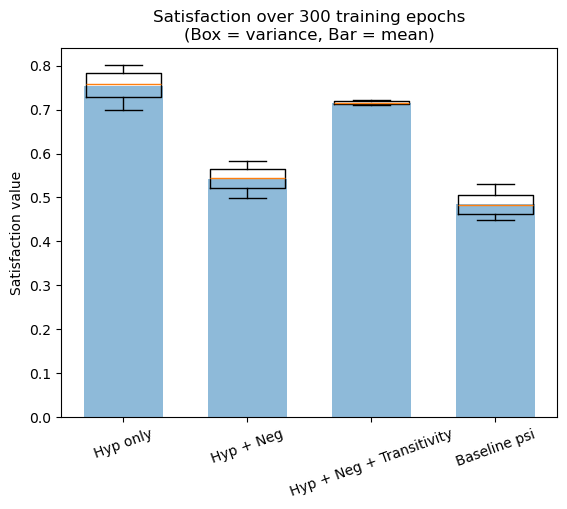

In [98]:
import matplotlib.pyplot as plt
import numpy as np

def to_scalar_list(x):
    return [v.detach().cpu().item() for v in x]

hyp_only_vals = to_scalar_list(hyp_only)
hyp_neg_only_vals = to_scalar_list(hyp_neg_only)
hyp_neg_trans_vals = to_scalar_list(hyp_neg_transitivity)
baseline_vals = to_scalar_list(baseline_psi)

data = [
    hyp_only_vals,
    hyp_neg_only_vals,
    hyp_neg_trans_vals,
    baseline_vals
]

labels = [
    'Hyp only',
    'Hyp + Neg',
    'Hyp + Neg + Transitivity',
    'Baseline psi'
]

means = [np.mean(d) for d in data]
positions = np.arange(1, len(data) + 1)

plt.figure()

# Boxplot
plt.boxplot(
    data,
    positions=positions,
    widths=0.6,
    showfliers=True
)

# Mean bars (inside the boxes)
plt.bar(
    positions,
    means,
    width=0.632,
    alpha=0.5,
)

plt.xticks(positions, labels, rotation=20)
plt.ylabel('Satisfaction value')
plt.title('Satisfaction over 300 training epochs\n(Box = variance, Bar = mean)')
plt.show()

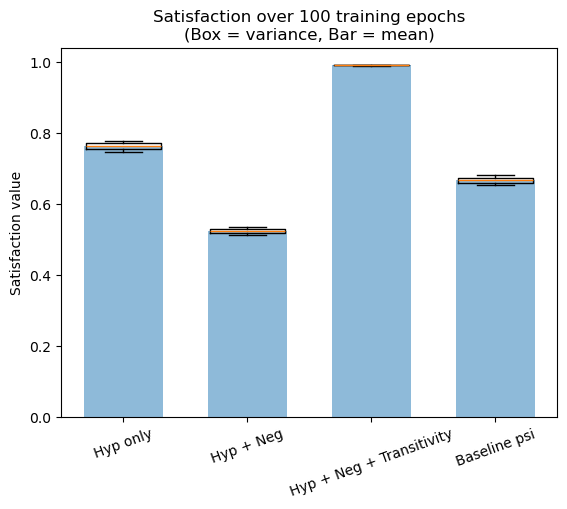

In [99]:
hyp_only_vals_100 = to_scalar_list(hyp_only_100)
hyp_neg_only_vals_100 = to_scalar_list(hyp_neg_only_100)
hyp_neg_trans_vals_100 = to_scalar_list(hyp_neg_transitivity_100)
baseline_vals_100 = to_scalar_list(baseline_psi_100)

data = [
    hyp_only_vals_100,
    hyp_neg_only_vals_100,
    hyp_neg_trans_vals_100,
    baseline_vals_100
]

labels = [
    'Hyp only',
    'Hyp + Neg',
    'Hyp + Neg + Transitivity',
    'Baseline psi'
]

means = [np.mean(d) for d in data]
positions = np.arange(1, len(data) + 1)

plt.figure()

# Boxplot
plt.boxplot(
    data,
    positions=positions,
    widths=0.6,
    showfliers=True
)

# Mean bars (inside the boxes)
plt.bar(
    positions,
    means,
    width=0.632,
    alpha=0.5,
)

plt.xticks(positions, labels, rotation=20)
plt.ylabel('Satisfaction value')
plt.title('Satisfaction over 100 training epochs\n(Box = variance, Bar = mean)')
plt.show()

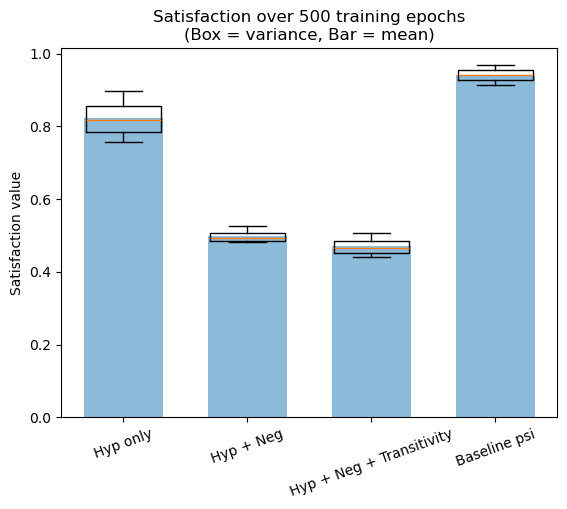

In [100]:
hyp_only_vals_500 = to_scalar_list(hyp_only_500)
hyp_neg_only_vals_500 = to_scalar_list(hyp_neg_only_500)
hyp_neg_trans_vals_500 = to_scalar_list(hyp_neg_transitivity_500)
baseline_vals_500 = to_scalar_list(baseline_psi_500)

data = [
    hyp_only_vals_500,
    hyp_neg_only_vals_500,
    hyp_neg_trans_vals_500,
    baseline_vals_500
]

labels = [
    'Hyp only',
    'Hyp + Neg',
    'Hyp + Neg + Transitivity',
    'Baseline psi'
]

means = [np.mean(d) for d in data]
positions = np.arange(1, len(data) + 1)

plt.figure()

# Boxplot
plt.boxplot(
    data,
    positions=positions,
    widths=0.6,
    showfliers=True
)

# Mean bars (inside the boxes)
plt.bar(
    positions,
    means,
    width=0.632,
    alpha=0.5,
)

plt.xticks(positions, labels, rotation=20)
plt.ylabel('Satisfaction value')
plt.title('Satisfaction over 500 training epochs\n(Box = variance, Bar = mean)')
plt.show()